<a href="https://colab.research.google.com/github/ocalzada/DS-Unit-2-Regression-Classification/blob/master/module3/assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [X] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [X] Do exploratory visualizations with Seaborn.
- [X] Do one-hot encoding of categorical features.
- [X] Do feature selection with `SelectKBest`.
- [X] Fit a linear regression model with multiple features.
- [X] Get mean absolute error for the test set.
- [X] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) instead of Linear Regression, especially if your errors blow up! Watch [Aaron Gallant's 9 minute video on Ridge Regression](https://www.youtube.com/watch?v=XK5jkedy17w) to learn more.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [0]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# dataset cleaning since we want one family dwellings > 100k & < 2M in sale price

mask = (df['SALE_PRICE'] > 100000) & (df['SALE_PRICE'] < 2000000) & (df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS')
df = df[mask]

# format our data values
pd.options.display.float_format = '{:,.0f}'.format

#convert sale date value from object to datetime
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)

In [0]:
# create my training and testing datasets
df.describe(exclude='number')
train = df[df.SALE_DATE.dt.month < 4]
test = df[df.SALE_DATE.dt.month ==4]

In [20]:
df.profile_report()

/usr/local/lib/python3.6/dist-packages/pandas_profiling/model/correlations.py:124: UserWarning: There was an attempt to calculate the cramers correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"cramers": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/pandas-profiling/pandas-profiling/issues
(include the error message: 'The internally computed table of expected frequencies has a zero element at (0, 0).')
  correlation_name=correlation_name, error=error


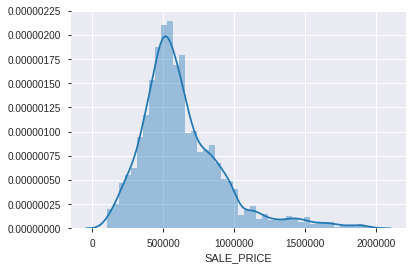

In [21]:
%matplotlib inline
import seaborn as sns
sns.distplot(df['SALE_PRICE']);

In [22]:
df['SALE_PRICE'].describe()

count       3,151
mean      628,560
std       292,990
min       104,000
25%       447,500
50%       568,000
75%       760,000
max     1,955,000
Name: SALE_PRICE, dtype: float64

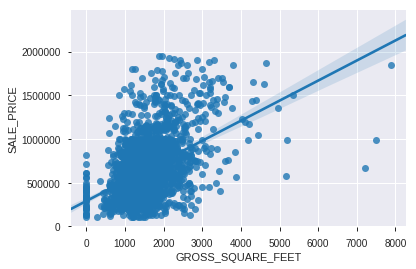

In [23]:
sns.regplot(x='GROSS_SQUARE_FEET', y="SALE_PRICE", data=df);

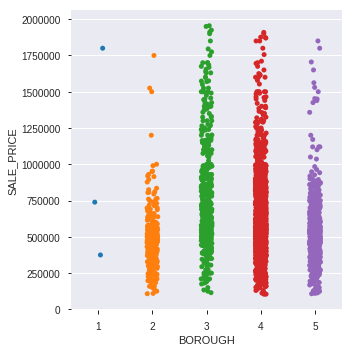

In [28]:
# wide range in sale_prices within NYC's 5 boroughs
sns.catplot(x="BOROUGH", y="SALE_PRICE", data=df);

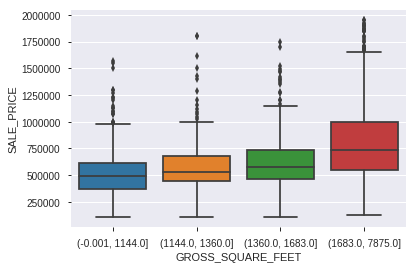

In [33]:
sqf_binned = pd.qcut(df['GROSS_SQUARE_FEET'], q=[0, .25, .5, .75, 1.])

sns.boxplot(x=sqf_binned, y="SALE_PRICE", data=df);

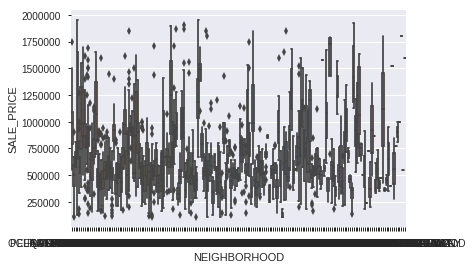

In [34]:
# SO MANY NEIGHBORHOODS! 183 to be exact.
sns.boxplot(x='NEIGHBORHOOD', y="SALE_PRICE", data=df);

In [48]:
sqf_binned.value_counts()


(1144.0, 1360.0]    797
(-0.001, 1144.0]    794
(1683.0, 7875.0]    783
(1360.0, 1683.0]    777
Name: GROSS_SQUARE_FEET, dtype: int64

In [50]:
price_binned = pd.qcut(df['SALE_PRICE'], q=[0, .25, .5, .75, 1.])
price_binned.value_counts()

(568000.0, 760000.0]      799
(447500.0, 568000.0]      788
(103999.999, 447500.0]    788
(760000.0, 1955000.0]     776
Name: SALE_PRICE, dtype: int64

In [51]:
df.isnull().sum()

BOROUGH                              0
NEIGHBORHOOD                         0
BUILDING_CLASS_CATEGORY              0
TAX_CLASS_AT_PRESENT                 0
BLOCK                                0
LOT                                  0
EASE-MENT                         3151
BUILDING_CLASS_AT_PRESENT            0
ADDRESS                              0
APARTMENT_NUMBER                  3150
ZIP_CODE                             0
RESIDENTIAL_UNITS                    0
COMMERCIAL_UNITS                     0
TOTAL_UNITS                          0
LAND_SQUARE_FEET                     0
GROSS_SQUARE_FEET                    0
YEAR_BUILT                           0
TAX_CLASS_AT_TIME_OF_SALE            0
BUILDING_CLASS_AT_TIME_OF_SALE       0
SALE_PRICE                           0
SALE_DATE                            0
dtype: int64

In [62]:
df.describe(exclude='number').T

,count,unique,top,freq,first,last
NEIGHBORHOOD,3151,183,FLUSHING-NORTH,97,NaN,NaN
BUILDING_CLASS_CATEGORY,3151,1,01 ONE FAMILY DWELLINGS,3151,NaN,NaN
TAX_CLASS_AT_PRESENT,3151,2,1,3111,NaN,NaN
BUILDING_CLASS_AT_PRESENT,3151,13,A1,1185,NaN,NaN
ADDRESS,3151,3135,216-29 114TH ROAD,2,NaN,NaN
APARTMENT_NUMBER,1,1,RP.,1,NaN,NaN
LAND_SQUARE_FEET,3151,1035,"4,000",289,NaN,NaN
BUILDING_CLASS_AT_TIME_OF_SALE,3151,11,A1,1186,NaN,NaN
SALE_DATE,3151,91,2019-01-31 00:00:00,78,2019-01-01 00:00:00,2019-04-30 00:00:00


In [71]:

import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
encoded = encoder.fit_transform(df['BUILDING_CLASS_AT_TIME_OF_SALE'])
encoded.head()

,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
44,1,0,0,0,0,0,0,0,0,0,0
61,0,1,0,0,0,0,0,0,0,0,0
78,0,1,0,0,0,0,0,0,0,0,0
108,0,1,0,0,0,0,0,0,0,0,0
111,0,0,1,0,0,0,0,0,0,0,0


In [0]:
train['BOROUGH'] = train['BOROUGH'].astype(str)
test['BOROUGH'] = test['BOROUGH'].astype(str)

In [0]:
#reduce cardinality of neighborhood feature
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index
# now replace the non-top10 neighborhoods with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10),'NEIGHBORHOOD'] = 'OTHER'
test.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

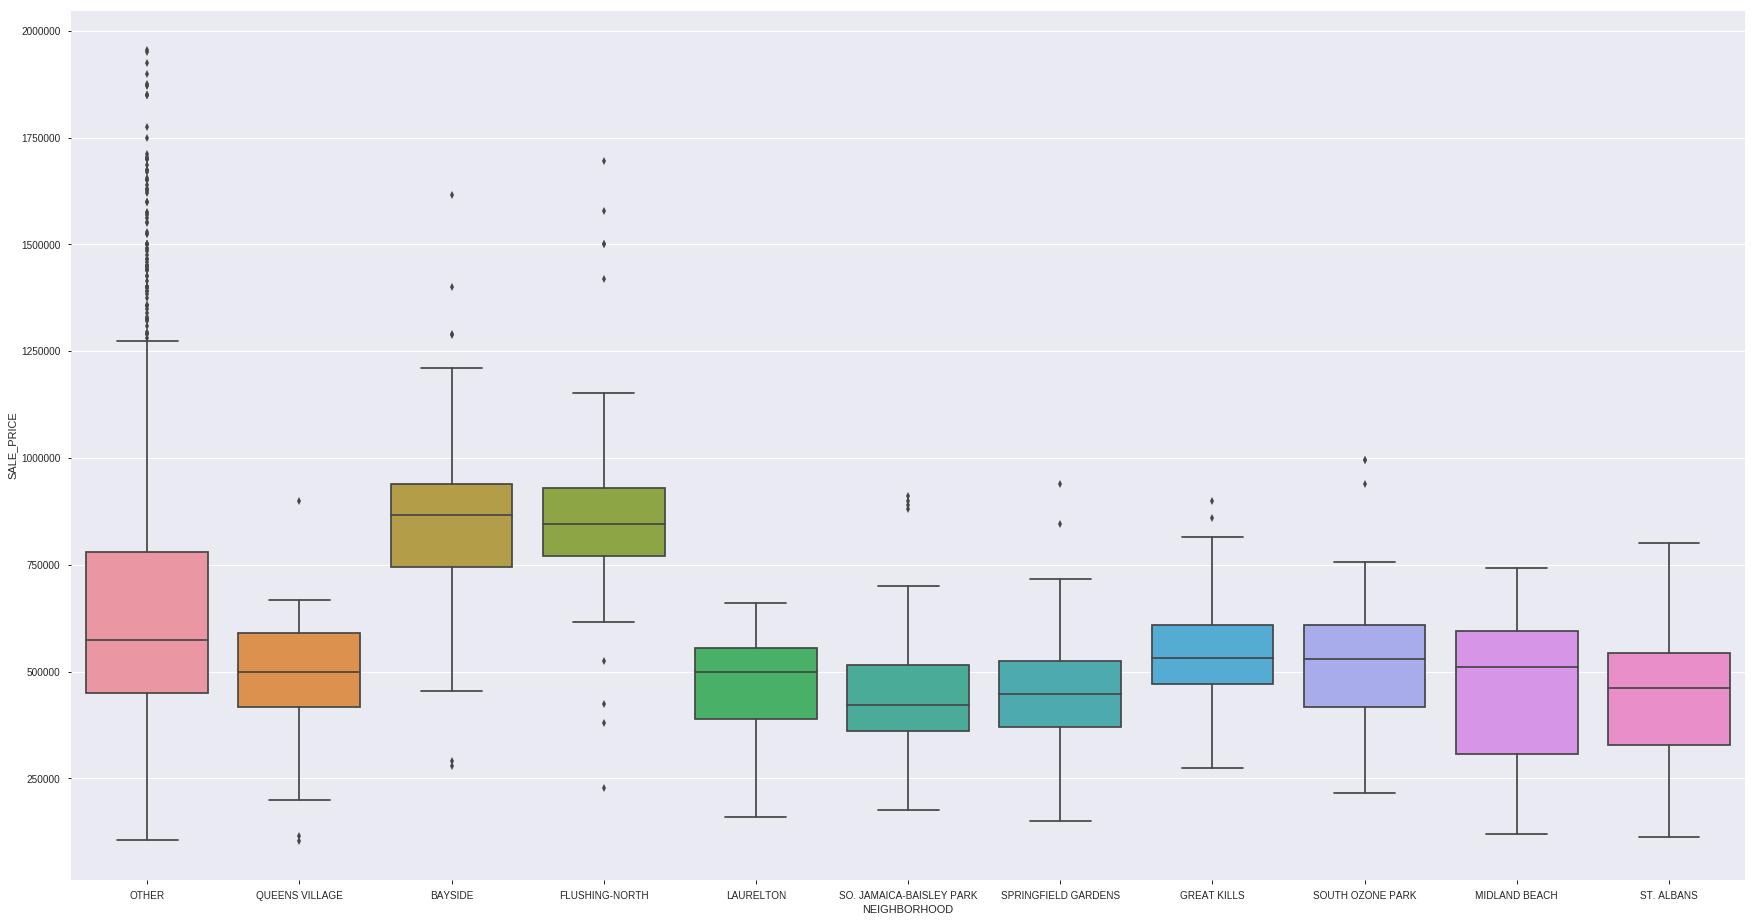

In [84]:
plt.figure(figsize=(30,16))
sns.boxplot(x='NEIGHBORHOOD', y="SALE_PRICE", data=train);

In [114]:
train['LAND_SQUARE_FEET'] = pd.to_numeric(train['LAND_SQUARE_FEET'], errors='coerce')
test['LAND_SQUARE_FEET'] = pd.to_numeric(test['LAND_SQUARE_FEET'], errors='coerce')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [115]:
train.dtypes

BOROUGH                                   object
NEIGHBORHOOD                              object
BUILDING_CLASS_CATEGORY                   object
TAX_CLASS_AT_PRESENT                      object
BLOCK                                      int64
LOT                                        int64
EASE-MENT                                float64
BUILDING_CLASS_AT_PRESENT                 object
ADDRESS                                   object
APARTMENT_NUMBER                          object
ZIP_CODE                                 float64
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                         float64
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                               float64
TAX_CLASS_AT_TIME_OF_SALE                  int64
BUILDING_CLASS_AT_TIME_OF_SALE            object
SALE_PRICE                                 int64
SALE_DATE           

In [0]:
#selecting columns with numeric values only
train_subset = train.select_dtypes('number').dropna(axis='columns')
test_subset = test.select_dtypes('number').dropna(axis='columns')

In [135]:
train_subset.dtypes

BLOCK                          int64
LOT                            int64
ZIP_CODE                     float64
RESIDENTIAL_UNITS            float64
COMMERCIAL_UNITS             float64
TOTAL_UNITS                  float64
GROSS_SQUARE_FEET            float64
YEAR_BUILT                   float64
TAX_CLASS_AT_TIME_OF_SALE      int64
SALE_PRICE                     int64
dtype: object

In [0]:
assert all(train_subset.columns == test_subset.columns)

In [0]:
target = 'SALE_PRICE'
features = train_subset.columns.drop(target)
X_train = train_subset[features]
y_train = train_subset[target]

X_test = test_subset[features]
y_test = test_subset[target]

In [138]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2507, 9), (2507,), (644, 9), (644,))

In [0]:
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func=f_regression, k=5)

In [0]:
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)


In [141]:
X_train_selected.shape, X_test_selected.shape

((2507, 5), (644, 5))

In [142]:
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

for name in selected_names:
  print(name)

BLOCK
ZIP_CODE
COMMERCIAL_UNITS
TOTAL_UNITS
GROSS_SQUARE_FEET


In [143]:
for name in unselected_names:
  print(name)

LOT
RESIDENTIAL_UNITS
YEAR_BUILT
TAX_CLASS_AT_TIME_OF_SALE


In [145]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: ${mae:,.0f}')


Test MAE: $167,908
